In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from skimage import io
from wordcloud import WordCloud
from nltk.corpus import stopwords, reuters
from nltk.tokenize import word_tokenize
import requests, time, nltk, re, os
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('reuters')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

1. Зниження розмірності і візуалізація даних

Точність без PCA: 0.7611
Час навчання без PCA: 0.0109 секунд
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        63
           1       0.61      0.56      0.58        54
           2       0.84      0.83      0.83        63

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180



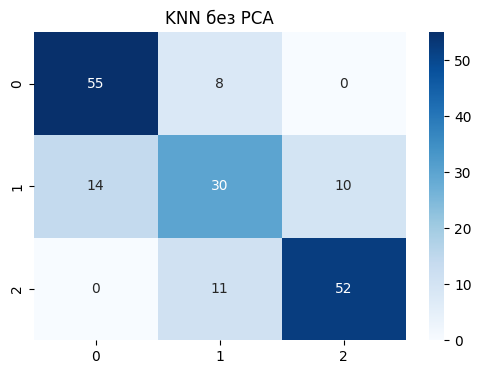

Точність після PCA: 0.8333
Час навчання після PCA: 0.0061 секунд
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        63
           1       0.73      0.70      0.72        54
           2       0.92      0.94      0.93        63

    accuracy                           0.83       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.83      0.83      0.83       180



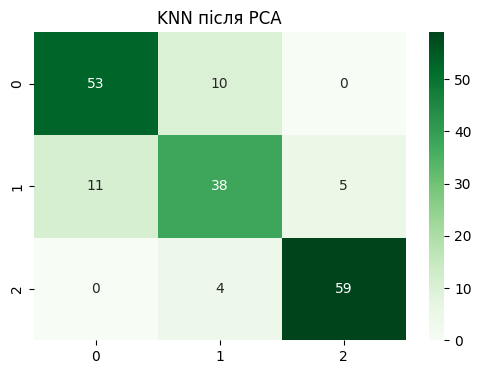


=== Порівняння ===
Без PCA: accuracy = 0.7611, час = 0.0109 с
Після PCA: accuracy = 0.8333, час = 0.0061 с



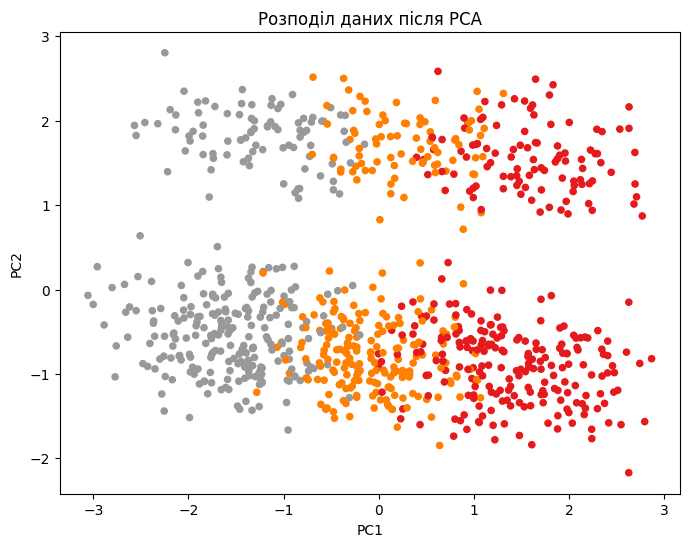

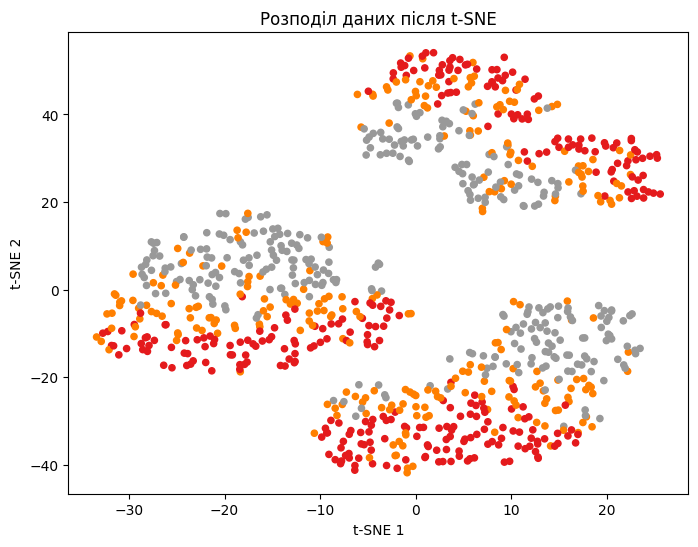

In [16]:
# Завантажуємо датасет Morning Routine
response = requests.get('https://www.kaggle.com/api/v1/datasets/download/jayeshx19/morning-routine-dataset')

datasetName='morning-routine-dataset.zip'
with open(datasetName, 'wb') as f:
    f.write(response.content)

df = pd.read_csv(datasetName)

# Перетворення категоріальних змінних в числові
le = LabelEncoder()
df_numeric = df.copy()
for col in df_numeric.select_dtypes(include=['object', 'datetime']).columns:
    df_numeric[col] = le.fit_transform(df_numeric[col].astype(str))

X = df_numeric.drop("Mood", axis=1)
y = df_numeric["Mood"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Навчання KNN без PCA
start = time.time()
knn_original = KNeighborsClassifier(n_neighbors=12)
knn_original.fit(X_train, y_train)
y_pred_original = knn_original.predict(X_test)
end = time.time()
acc_original = accuracy_score(y_test, y_pred_original)
time_original = end - start

print("Точність без PCA:", round(acc_original, 4))
print("Час навчання без PCA:", round(time_original, 4), "секунд")
print(classification_report(y_test, y_pred_original))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_original), annot=True, fmt='d', cmap='Blues')
plt.title("KNN без PCA")
plt.show()

# Навчання KNN після PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)


start = time.time()
knn_pca = KNeighborsClassifier(n_neighbors=12)
knn_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = knn_pca.predict(X_test_pca)
end = time.time()
acc_pca = accuracy_score(y_test_pca, y_pred_pca)
time_pca = end - start

print("Точність після PCA:", round(acc_pca, 4))
print("Час навчання після PCA:", round(time_pca, 4), "секунд")
print(classification_report(y_test_pca, y_pred_pca))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_pca, y_pred_pca), annot=True, fmt='d', cmap='Greens')
plt.title("KNN після PCA")
plt.show()

# Порівняння часу й точності
print("\n=== Порівняння ===")
print(f"Без PCA: accuracy = {acc_original:.4f}, час = {time_original:.4f} с")
print(f"Після PCA: accuracy = {acc_pca:.4f}, час = {time_pca:.4f} с")
print()
# Візуалізація PCA
plt.figure(figsize=(8,6))
plt.title("Розподіл даних після PCA")
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='Set1', s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.title("Розподіл даних після t-SNE")
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='Set1', s=20)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

Зменшення розмірності позитивно вплинуло на алгоритм.
Після зниження розмірності на алгоритм точність зросла приблизно на 0.07 пунктів. Швидкість з PCA 0.0064 що на  0.0001 сек. більше показника без PCA, тобто швидкість навчання майже не змінилась.

2. Кластерний аналіз

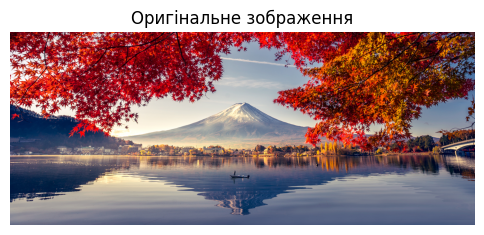

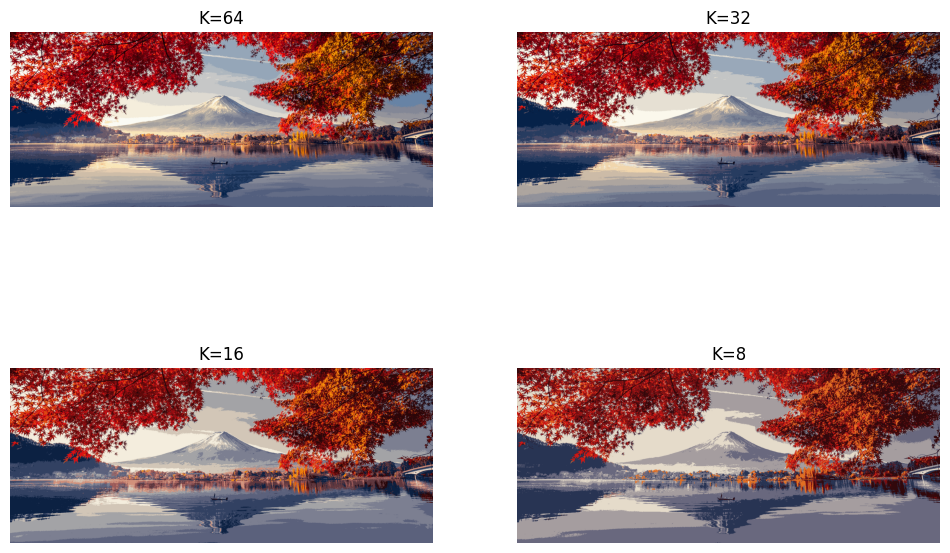

In [24]:
image_url = "https://helpx.adobe.com/content/dam/help/en/photoshop/using/convert-color-image-black-white/jcr_content/main-pars/before_and_after/image-before/Landscape-Color.jpg"

plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.title('Оригінальне зображення')
plt.axis('off')
plt.show()
print()
img = io.imread(image_url)
img_data = img.reshape((-1, 3))

def quantize_image(k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(img_data)
    new_colors = kmeans.cluster_centers_[labels].astype("uint8")
    new_image = new_colors.reshape(img.shape)
    return new_image

plt.figure(figsize=(12,8))
for i, k in enumerate([64, 32, 16, 8], 1):
    plt.subplot(2,2,i)
    plt.imshow(quantize_image(k))
    plt.title(f"K={k}")
    plt.axis('off')
plt.show()

При використанні 64 кольорів зображення зберегло високу якість із мінімальними втратами деталей. Зі зменшенням кількості кольорів до 32 спостерігається незначна втрата деталізації, але зображення залишається натуралістичним.
При 16 кольорах стають помітними кольорові плями та згладжування дрібних деталей. Найбільш помітні зміни відбуваються при використанні лише 8 кольорів - місцями зображення набуває вигляду піксельної графіки з чіткими кольоровими зонами.

3. Обробка та класифікація текстових даних

            fileid                                            cleaned  len
498  training/9034  altron inc alrn qtr jan shr loss cts loss five...  257
499  training/3382  americus trust byu byp initial qtrly div ameri...  145
500  training/1483  usf corp raises quarterly dividend qtly div ct...   92
501     test/20286  fireman fund corp ffc qtr net shr dlrs cts net...  322
502     test/18875  rochester community savings bank rcsb second q...  332
503     test/16568  health rehabilitation hrp sets first divi heal...  293
504  training/5530  radix ventures inc qtr jan loss shr loss three...  148
505  training/8245  supermarkets general corp qtr cts cts supermar...   75
506  training/5594  bkla bancorp dec year net shr cts cts net loan...   87
507     test/15729  home savings bank hmsb qtr net shr cts given n...  256

           fileid                                            cleaned   len
0  training/12866  donnelly dny sell cable system donnelly sons s...   361
1      test/16676  inter

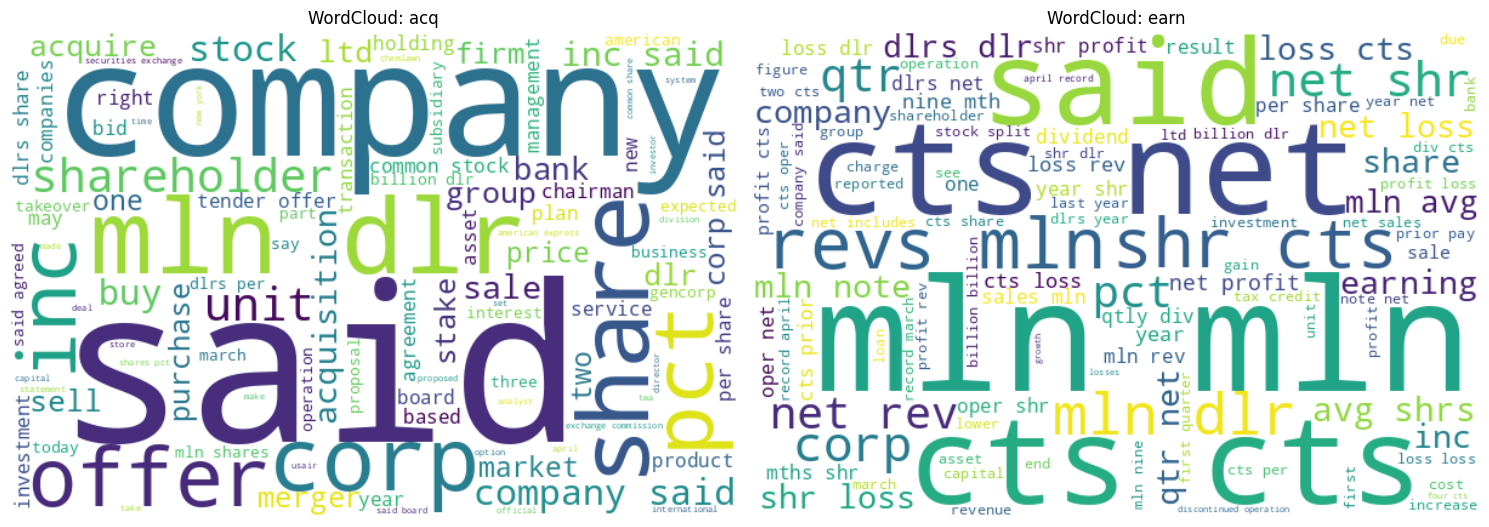

Точність класифікації текстів: 0.9564
              precision    recall  f1-score   support

         acq       0.93      0.99      0.96       148
        earn       0.99      0.93      0.96       150

    accuracy                           0.96       298
   macro avg       0.96      0.96      0.96       298
weighted avg       0.96      0.96      0.96       298



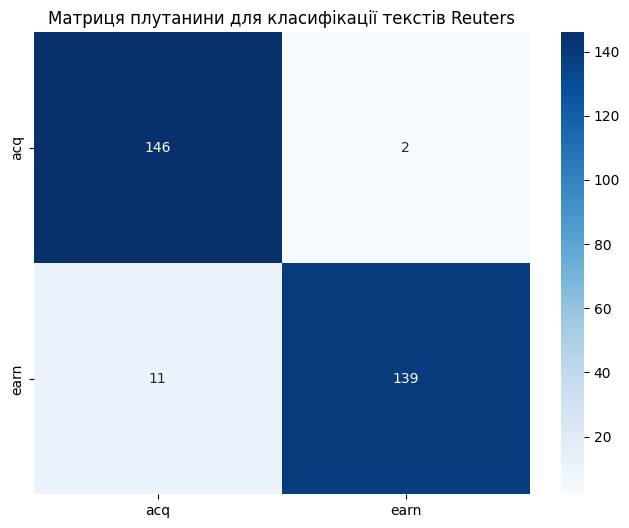

In [30]:
def clean_text_simple(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()
    STOPWORDS = set(stopwords.words('english'))
    tokens = [t for t in text.split() if t not in STOPWORDS and len(t) > 2]
    return " ".join(tokens)


def load_reuters_earn_acq(max_docs_per_cat=None):
    selected = ['earn',  # статті про прибутки/доходи
                'acq']   # статті про злиття та поглинання компаній
    rows = []
    for fid in reuters.fileids():
        cats = reuters.categories(fid)
        common = [c for c in cats if c in selected]
        if common:
            rows.append((fid, reuters.raw(fid), common[0]))
    df = pd.DataFrame(rows, columns=['fileid', 'text', 'target_name'])
    if max_docs_per_cat is not None:
        df_list = []
        for cat, g in df.groupby('target_name'):
            df_list.append(g.sample(min(len(g), max_docs_per_cat), random_state=42))
        df = pd.concat(df_list).reset_index(drop=True)

    # Очищення тексту
    df['cleaned'] = df['text'].apply(clean_text_simple)
    df = df[df['cleaned'].str.len() > 50].reset_index(drop=True)
    df['target'] = pd.factorize(df['target_name'])[0]
    return df

# Завантаження даних Reuters збірки новин
df_reuters = load_reuters_earn_acq(max_docs_per_cat=500)

print(df_reuters[df_reuters['target_name']=='earn'][['fileid','cleaned']].head(10).assign(len=lambda d: d['cleaned'].str.len()))
print()
print(df_reuters[df_reuters['target_name']=='acq'][['fileid','cleaned']].head(10).assign(len=lambda d: d['cleaned'].str.len()))
print()
# Візуалізація слів за допомогою WordCloud
plt.figure(figsize=(15, 7))

for i, category in enumerate(df_reuters['target_name'].unique()):
    text = " ".join(df_reuters[df_reuters['target_name'] == category]['cleaned'].tolist())
    wc = WordCloud(width=600, height=400, background_color='white', max_words=100).generate(text)
    plt.subplot(1, 2, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud: {category}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Векторизація та класифікація
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = vectorizer.fit_transform(df_reuters['cleaned'])
y_text = df_reuters['target']

X_train, X_test, y_train, y_test = train_test_split(X_text, y_text, test_size=0.3, random_state=42)
rf_text = RandomForestClassifier(n_estimators=100, random_state=42)
rf_text.fit(X_train, y_train)
y_pred = rf_text.predict(X_test)
text_score = accuracy_score(y_test, y_pred)

print(f"Точність класифікації текстів: {text_score:.4f}")
print(classification_report(y_test, y_pred, target_names=['acq', 'earn']))

# Матриця плутанини
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['acq', 'earn'],
            yticklabels=['acq', 'earn'])
plt.title('Матриця плутанини для класифікації текстів Reuters')
plt.show()

Точність класифікації на рівні 96% свідчить про високу ефективність обробки текстових даних. Модель успішно розрізняє тексти за темами acq та earn.